In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import io
import os
import re
from sklearn.utils import shuffle
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from sklearn.neighbors import KNeighborsClassifier
import multiprocessing
from sklearn.svm import SVC, NuSVC, LinearSVC, NuSVR
from sklearn.metrics import accuracy_score
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import cohen_kappa_score
from pprint import pprint
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from bs4 import BeautifulSoup

Using TensorFlow backend.


In [3]:
path = 'training_data_5151/'
list_of_labels = os.listdir(path)
list_of_labels

['pos', 'training_data_5151.arff', 'neu', 'neg']

In [4]:
reviews = []
pos = []
lpos = []
neg = []
lneg = []
neu = []
lneu = []
labels = []
klabels = []
for i in list_of_labels:
    if i != '.DS_Store':
        if i == 'neg':
            list_of_text = os.listdir(path+i)
            for ltext in list_of_text:
                with io.open(path+i+'/'+ltext, encoding='utf-8') as f:
                    review = f.read()
                    reviews.append(review)
                    neg.append(review)
                    labels.append([0,1,0])
                    klabels.append(0)
                    lneg.append(0)

        if i == 'neu':
            list_of_text = os.listdir(path+i)
            for ltext in list_of_text:
                with io.open(path+i+'/'+ltext, encoding='utf-8') as f:
                    review = f.read()
                    reviews.append(review)
                    neu.append(review)
                    labels.append([0,0,1])
                    klabels.append(1)
                    lneu.append(1)
        if i == 'pos':
            list_of_text = os.listdir(path+i)
            for ltext in list_of_text:
                with io.open(path+i+'/'+ltext, encoding='utf-8') as f:
                    review = f.read()
                    reviews.append(review)
                    pos.append(review)
                    labels.append([1,0,0])
                    klabels.append(2)
                    lpos.append(2)

In [23]:
with open("test.xml") as fp:
    xml_doc = BeautifulSoup(fp, 'lxml')
xtext = []
xlabels = []
xone_hot_labels = []
for i in xml_doc.find_all('sentence'):
    if i.attrs['polarity'] == 'neutral':
        xlabels.append(1)
        xone_hot_labels.append([0,0,1])
        for j in i.children:
            xtext.append(j.text)
    if i.attrs['polarity'] == 'positive':
        xlabels.append(2)
        xone_hot_labels.append([1,0,0])
        for j in i.children:
            xtext.append(j.text)
    if i.attrs['polarity'] == 'negative':
        xlabels.append(0)
        xone_hot_labels.append([0,1,0])
        for j in i.children:
            xtext.append(j.text)
print(len(xtext))
print(len(xlabels))
xone_hot_labels = np.array(xone_hot_labels, dtype=np.float32)

0
0


In [24]:
len(reviews)

5151

In [25]:
len(reviews)

5151

In [26]:
labels = np.array(labels, dtype='float')
labels[:5]

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [27]:
print(len(pos))
print(len(neu))
print(len(neg))

1391
2378
1382


In [28]:
rreviews = neg + neu+ pos
rlabels = lneg + lneu + lpos
rtestx = neg[910:1300] + neu[910:1300] + pos[910:1300]
rtesty = lneg[910:1300] + lneu[910:1300] + lpos[910:1300]

In [29]:
vocab = set()
for review in reviews+xtext:
    for word in review.split(' '):
        vocab.add(word)

In [30]:
len(vocab)

10577

In [31]:
word2index = {}
for i,word in enumerate(vocab):
    word2index[word] = i

In [32]:
import pickle
with open('word2index.pkl', 'wb') as f:
    pickle.dump(word2index, f)

In [33]:
def encode(text):
    vector = np.zeros(11993)
    for word in text.split(' '):
        vector[word2index[word]] = 1
    return vector

In [34]:
encode('कहानी को ठीक से समेटा नहीं गया है')

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [35]:
reviews, labels = shuffle(reviews, labels)

In [36]:
trainx = reviews[:4100]
trainy = labels[:4100]
testx = reviews[:-4100]
testy = labels[:-4100]
testy2 = klabels[:-4100]
print(len(trainx))
print(len(testx))

4100
1051


# 3-layer perceptron

In [40]:
x = tf.placeholder(tf.float32, shape=[None, 11993])
y = tf.placeholder(tf.float32)

weights = {'l1': tf.Variable(tf.truncated_normal([11993, 400])),
           'l2': tf.Variable(tf.truncated_normal([400, 600])),
           'l3': tf.Variable(tf.truncated_normal([600, 400])),
           'out': tf.Variable(tf.truncated_normal([400, 3]))}

biases = {'l1': tf.Variable(tf.truncated_normal([400])),
          'l2': tf.Variable(tf.truncated_normal([600])),
          'l3': tf.Variable(tf.truncated_normal([400])),
          'out': tf.Variable(tf.truncated_normal([3]))}

output = tf.nn.relu(tf.matmul(x, weights['l1']) + biases['l1'])
output = tf.nn.relu(tf.matmul(output, weights['l2']) + biases['l2'])
output = tf.nn.relu(tf.matmul(output, weights['l3']) + biases['l3'])
output = tf.matmul(output, weights['out']) + biases['out']
final = tf.nn.softmax(output)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

In [42]:
num_epochs = 10

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    for epoch in range(num_epochs):
        loss = 0
        for review, label in zip(trainx, trainy):
            inx = encode(review)
            inx = inx.reshape((1,11993))
            c, opt = sess.run([cost, optimizer], feed_dict={x:inx, y:label})
            loss += c
        print('Epoch: {} , Loss: {}'.format(epoch+1, loss))
    
    correct = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
    final_r = []
    final_l = []
    for review,label in zip(testx,testy):
        final_r.append(encode(review))
        final_l.append(label)
    print('Accuracy:',accuracy.eval({x:np.array(final_r), y:np.array(final_l)}))
    predicts = final.eval({x:np.array(final_r), y:np.array(final_l)})
    corrects = correct.eval({x:np.array(final_r), y:np.array(final_l)})
    print(predicts[:5])

Epoch: 1 , Loss: 9979227.614534145
Epoch: 2 , Loss: 1878792.977722846


KeyboardInterrupt: 

# Naive Bayes

In [43]:
def word_feats(words):
    return dict([(word, True) for word in words])

def get_words(file):
    with io.open(file, encoding='utf-8') as f:
        x = f.read()
    return x.split(' ')

neg_ids = os.listdir(path+'neg/')
pos_ids = os.listdir(path+'pos/')
neu_ids = os.listdir(path+'neu/')

In [44]:
negfeats = [(word_feats(get_words(path+'neg/'+f)), 'neg') for f in neg_ids]
neglabels = [0 for f in neg_ids]
posfeats = [(word_feats(get_words(path+'pos/'+f)), 'pos') for f in pos_ids]
poslabels = [2 for f in pos_ids]
neufeats = [(word_feats(get_words(path+'neu/'+f)), 'neu') for f in neu_ids]
neulabels = [1 for f in neu_ids]

In [45]:
trainx = negfeats+ posfeats + neufeats
testx = negfeats[:-690] + posfeats[:-690] + neufeats
testy = neglabels[:-690] + poslabels[:-690] + neulabels[:-690]
total = negfeats + posfeats + neufeats
labels = neglabels + poslabels + neulabels
print ('train on %d instances, test on %d instances' % (len(trainx), len(testx)))

train on 5151 instances, test on 3771 instances


In [46]:
classifier = NaiveBayesClassifier.train(trainx)

In [47]:
print( 'accuracy:', nltk.classify.util.accuracy(classifier, testx))

accuracy: 0.8194112967382657


In [49]:
import pickle
with open('naivebayes.pkl', 'wb') as  f:
    pickle.dump(classifier, f, protocol=2)

In [50]:
classifier.classify(testx[0][0])

'neg'

In [51]:
predict = []
for i in testx:
    if classifier.classify(i[0]) == 'pos':
        predict.append(2)
    if classifier.classify(i[0]) == 'neg':
        predict.append(0)
    if classifier.classify(i[0]) == 'neu':
        predict.append(1)
        

In [52]:
matrix = confusion_matrix(predict, testy)

ValueError: Found input variables with inconsistent numbers of samples: [3771, 3081]

In [53]:
plot_confusion_matrix(matrix)

NameError: name 'matrix' is not defined

In [391]:
cohen_kappa_score(testy, predict)

0.92333457828682541

In [392]:
mean_absolute_error(testy, predict)

0.070877531340405017

In [393]:
sklearn.metrics.recall_score(testy, predict, average='weighted')

0.94889103182256507

In [394]:
sklearn.metrics.f1_score(testy, predict, average='weighted')

0.94890531630732911

In [395]:
np.sqrt(sklearn.metrics.mean_squared_error(testy, predict))

0.33228701098048541

In [30]:
sklearn.metrics.r2_score(testy, predict)

0.7425245647854618

In [397]:
sklearn.metrics.precision_score(testy, predict, average='weighted')

0.94985863813303495

In [32]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(testy, predict, pos_label=1)
print("Multinomial naive bayes AUC: {0}".format(sklearn.metrics.auc(fpr, tpr)))

Multinomial naive bayes AUC: 0.4921530815421037


In [33]:
classifier.show_most_informative_features()

Most Informative Features
                   तारीफ = True              pos : neg    =     19.7 : 1.0
                   अच्छा = True              pos : neu    =     15.3 : 1.0
                  लोकेशन = True              pos : neg    =     14.3 : 1.0
                 बेहतरीन = True              pos : neg    =     13.1 : 1.0
                    करनी = True              pos : neg    =     13.0 : 1.0
                   अलावा = True              neg : neu    =     12.3 : 1.0
                    होगी = True              pos : neg    =     11.7 : 1.0
                प्रभावित = True              pos : neu    =     11.4 : 1.0
                   मेहनत = True              pos : neu    =     11.0 : 1.0
                   कंगना = True              pos : neg    =     10.2 : 1.0


# MultinomialNB

In [12]:
def encode(text):
    vector = np.zeros(11993)
    for word in text.split(' '):
        vector[word2index[word]] = 1
    return vector

other_reviews = []
for i in reviews:
    other_reviews.append(encode(i))

In [21]:
other_reviews, klabels = shuffle(other_reviews, klabels)

In [48]:
test = []
for i in xtext:
    test.append(encode(i))

In [58]:
total = xtext + reviews
total_labels = klabels + xlabels
print(len(total))
total, total_labels = shuffle(total, total_labels)

6095


In [195]:
vectorizer = CountVectorizer(ngram_range=(1, 4), analyzer='char')
vectorizer.fit(total)
train_features = vectorizer.transform(reviews)
test_features = vectorizer.transform(xtext)

In [196]:
len(vectorizer.vocabulary_)

66736

In [197]:
lg = LogisticRegression()

In [198]:
lg.fit(train_features, klabels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [199]:
lg.score(test_features, xlabels)

0.33316248077908767

In [95]:
from sklearn.externals import joblib
with open('logisticreg.pkl', 'wb') as f:
    pickle.dump(lg, f)

In [96]:
import pickle
with open('vectorizer.pkl','wb') as f:
    pickle.dump(vectorizer, f)

In [39]:
x = vectorizer.transform(['कहानी को ठीक से समेटा नहीं गया है'])
abc = AdaBoostClassifier()

In [40]:
abc.fit(train_features, rlabels)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [41]:
abc.score(test_features, rtesty)

0.61213235294117652

In [200]:
nb = MultinomialNB()
nb.fit(train_features, klabels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [25]:
predictions = nb.predict(test_features)

In [201]:
nb.score(test_features, xlabels)

0.33880061506919529

In [99]:
from sklearn.externals import joblib
with open('multinomialnb.pkl', 'wb') as f:
    pickle.dump(nb, f)

(<matplotlib.figure.Figure at 0x1251c0a20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10a609a58>)

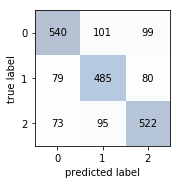

In [403]:
cmatrix = confusion_matrix(predictions, rtesty)
plot_confusion_matrix(cmatrix)

In [73]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(testY, predictions, pos_label=1)
print("Multinomial naive bayes AUC: {0}".format(sklearn.metrics.auc(fpr, tpr)))

Multinomial naive bayes AUC: 0.4864642033811476


In [75]:
fpr

array([ 0.        ,  0.234375  ,  0.80859375,  1.        ])

In [404]:
mean_absolute_error(rtesty, predictions)

0.33702989392478305

In [405]:
cohen_kappa_score(rtesty, predictions)

0.61878483870000167

In [47]:
pprint(classification_report(klabels[:-4651], predictions))

('             precision    recall  f1-score   support\n'
 '\n'
 '          0       0.81      0.36      0.50       139\n'
 '          1       0.56      0.88      0.69       230\n'
 '          2       0.63      0.38      0.48       131\n'
 '\n'
 'avg / total       0.65      0.60      0.58       500\n')


In [406]:
sklearn.metrics.recall_score(rtesty, predictions, average='weighted')

0.74590163934426235

In [407]:
sklearn.metrics.f1_score(rtesty, predictions, average='weighted')

0.74569469771439179

In [408]:
np.sqrt(sklearn.metrics.mean_squared_error(rtesty, predictions))

0.70914946271069945

In [51]:
sklearn.metrics.r2_score(klabels[:-4651], predictions)

0.1218058931641669

In [409]:
sklearn.metrics.precision_score(rtesty, predictions, average='weighted')

0.74646076129976169

# KNeighbors

In [504]:
wvocab = set()
for review in reviews:
    for word in review.split(' '):
        wvocab.add(word)

In [505]:
len(wvocab)

9451

In [17]:
word2index = {}
for i,word in enumerate(wvocab):
    word2index[word] = i

In [18]:
def encode(text):
    vector = []
    for word in text.split(' '):
        vector.append(word2index[word])
    return vector

In [19]:
encode('कहानी को ठीक से समेटा नहीं गया है')

[4730, 5772, 8482, 1943, 7014, 1936, 1877, 9311]

In [20]:
freviews = []
for review in reviews:
    freviews.append(encode(review))

In [21]:
reviews = pad_sequences(freviews)
len(reviews)

5151

In [22]:
reviews, klabels = shuffle(reviews, klabels)

In [23]:
trainX = reviews[:3605]
trainY = klabels[:3605]
testX = reviews[:-3605]
testY = klabels[:-3605]
print(len(trainX))
print(len(testX))

3605
1546


In [202]:
neigh = KNeighborsClassifier(n_neighbors=3, n_jobs=multiprocessing.cpu_count())

In [325]:
scores = cross_val_score(neigh, train_features, trainY, cv=10)

In [326]:
scores

array([ 0.35009671,  0.33914729,  0.37669903,  0.39417476,  0.36504854,
        0.37087379,  0.3592233 ,  0.40194175,  0.35797665,  0.38521401])

In [203]:
neigh.fit(train_features, klabels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=3, p=2,
           weights='uniform')

In [204]:
neigh.score(test_features, xlabels)

0.31317273193234241

In [103]:
from sklearn.externals import joblib
with open('knn.pkl', 'wb') as f:
    pickle.dump(neigh, f)

In [413]:
predict = neigh.predict(test_features)
cmatrix = confusion_matrix(predict, rtesty)

(<matplotlib.figure.Figure at 0x12b69b160>,
 <matplotlib.axes._subplots.AxesSubplot at 0x123c7bf98>)

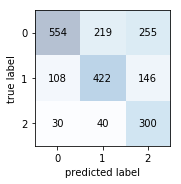

In [414]:
plot_confusion_matrix(cmatrix)

In [415]:
mean_absolute_error(rtesty, predict)

0.52217936354869821

In [416]:
cohen_kappa_score(rtesty, predict)

0.42340196782718897

In [23]:
pprint(classification_report(klabels[:-4651], predict))

('             precision    recall  f1-score   support\n'
 '\n'
 '          0       0.55      0.79      0.65       133\n'
 '          1       0.75      0.73      0.74       224\n'
 '          2       0.84      0.54      0.66       143\n'
 '\n'
 'avg / total       0.72      0.69      0.69       500\n')


In [417]:
sklearn.metrics.recall_score(rtesty, predict, average='weighted')

0.61523625843780139

In [418]:
sklearn.metrics.f1_score(rtesty, predict, average='weighted')

0.60850951375922091

In [419]:
np.sqrt(sklearn.metrics.mean_squared_error(rtesty, predict))

0.89275450574147042

In [27]:
sklearn.metrics.r2_score(klabels[:-4651], predict)

0.0029006526468453586

In [420]:
sklearn.metrics.precision_score(rtesty, predict, average='weighted')

0.65883594512653654

In [29]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(testY, predict, pos_label=1)
print("Multinomial naive bayes AUC: {0}".format(sklearn.metrics.auc(fpr, tpr)))

Multinomial naive bayes AUC: 0.5360539596273293


In [30]:
tpr

array([ 0.        ,  0.04464286,  0.77232143,  1.        ])

# SVM

In [205]:
clf = SVC()

In [138]:
scores = cross_val_score(clf, reviews, klabels, cv=ShuffleSplit(test_size=0.3))

In [139]:
scores

array([ 0.4469599 ,  0.46701164,  0.44178525,  0.45730918,  0.46442432,
        0.47477361,  0.46701164,  0.47347995,  0.46895213,  0.46571798])

In [227]:
print("Accuracy: %f (+/- %f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.461464 (+/- 0.001952)


In [206]:
clf.fit(train_features, klabels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [207]:
clf.score(test_features, xlabels)

0.42132239876986161

In [107]:
from sklearn.externals import joblib
with open('svm10.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [424]:
prediction = clf.predict(test_features)

In [425]:
matrix = confusion_matrix(prediction, rtesty)

(<matplotlib.figure.Figure at 0x12bb95da0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12c040cc0>)

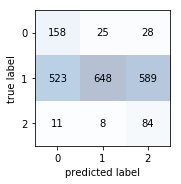

In [426]:
plot_confusion_matrix(matrix)

In [427]:
cohen_kappa_score(rtesty, prediction)

0.14874505191352594

In [428]:
sklearn.metrics.recall_score(rtesty, prediction, average='weighted')

0.42912246865959497

In [429]:
sklearn.metrics.f1_score(rtesty, prediction, average='weighted')

0.36171773816313307

In [430]:
mean_absolute_error(rtesty, prediction)

0.58968177434908386

In [431]:
np.sqrt(sklearn.metrics.mean_squared_error(rtesty, prediction))

0.79201657834065675

In [41]:
sklearn.metrics.r2_score(klabels[:-4651], prediction)

1.0

In [432]:
sklearn.metrics.precision_score(rtesty, prediction, average='weighted')

0.64638439409686466

In [43]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(testY, prediction, pos_label=1)
print("Multinomial naive bayes AUC: {0}".format(sklearn.metrics.auc(fpr, tpr)))

Multinomial naive bayes AUC: 0.5183823529411764


In [156]:
tpr

array([ 0.     ,  0.09375,  0.90625,  1.     ])

# Random forests

In [208]:
rf = RandomForestClassifier()

In [209]:
rf.fit(train_features, klabels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [231]:
scores = cross_val_score(rf, reviews, klabels, cv=5)

In [232]:
scores

array([ 0.40697674,  0.40543162,  0.41359223,  0.42468416,  0.40816327])

In [210]:
rf.score(test_features, xlabels)

0.33777549974372117

In [111]:
from sklearn.externals import joblib
with open('randomforest.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [436]:
pred = rf.predict(test_features)

In [437]:
matrix = confusion_matrix(pred, rtesty)

(<matplotlib.figure.Figure at 0x12c130c88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12bc27048>)

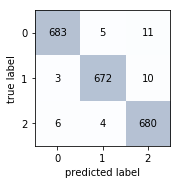

In [438]:
plot_confusion_matrix(matrix)

In [439]:
cohen_kappa_score(rtesty, pred)

0.97179306826317402

In [177]:
pprint(classification_report(testY, pred))

('             precision    recall  f1-score   support\n'
 '\n'
 '          0       0.99      0.99      0.99       141\n'
 '          1       0.97      1.00      0.99       229\n'
 '          2       1.00      0.95      0.98       130\n'
 '\n'
 'avg / total       0.99      0.99      0.99       500\n')


In [440]:
sklearn.metrics.recall_score(rtesty, pred, average='weighted')

0.98119575699132111

In [441]:
sklearn.metrics.f1_score(rtesty, pred, average='weighted')

0.9811825176142206

In [442]:
mean_absolute_error(rtesty, pred)

0.027000964320154291

In [443]:
np.sqrt(sklearn.metrics.mean_squared_error(rtesty, pred))

0.20831324236136575

In [182]:
sklearn.metrics.r2_score(testY, pred)

0.96306664992354796

In [444]:
sklearn.metrics.precision_score(rtesty, pred, average='weighted')

0.98123274880295575

In [184]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(testY, pred, pos_label=1)
print("RandomForest AUC: {}".format(sklearn.metrics.auc(fpr, tpr)))

RandomForest AUC: 0.5313653136531366


# AdaBoost

In [112]:
abc = AdaBoostClassifier()

In [323]:
scores = cross_val_score(abc, reviews, klabels, cv=10)

In [324]:
scores

array([ 0.4410058 ,  0.47093023,  0.47378641,  0.49126214,  0.47378641,
        0.46019417,  0.46019417,  0.46213592,  0.47081712,  0.45525292])

In [113]:
abc.fit(train_features, klabels)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [114]:
abc.score(test_features, xlabels)

0.29830855971296771

In [115]:
from sklearn.externals import joblib
with open('adaboost.pkl', 'wb') as f:
    pickle.dump(abc, f)

In [448]:
pred = abc.predict(test_features)

In [449]:
mat = confusion_matrix(pred, rtesty)

(<matplotlib.figure.Figure at 0x12b7ed320>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12cba4f98>)

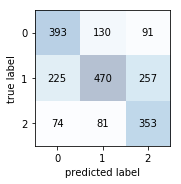

In [450]:
plot_confusion_matrix(mat)

In [451]:
cohen_kappa_score(rtesty, pred)

0.38043596335590402

In [61]:
pprint(classification_report(testY, pred))

('             precision    recall  f1-score   support\n'
 '\n'
 '          0       0.68      0.35      0.46       133\n'
 '          1       0.52      0.89      0.65       224\n'
 '          2       0.64      0.20      0.30       143\n'
 '\n'
 'avg / total       0.59      0.55      0.50       500\n')


In [452]:
sklearn.metrics.recall_score(rtesty, pred, average='weighted')

0.58630665380906466

In [453]:
sklearn.metrics.f1_score(rtesty, pred, average='weighted')

0.58718690881808822

In [454]:
mean_absolute_error(rtesty, pred)

0.49324975891996142

In [455]:
np.sqrt(sklearn.metrics.mean_squared_error(rtesty, pred))

0.80768965845676988

In [329]:
sklearn.metrics.r2_score(rtesty, pred)

0.04002280491615906

In [456]:
sklearn.metrics.precision_score(rtesty, pred, average='weighted')

0.61053291675550214

In [68]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(testY, pred, pos_label=1)
print("RandomForest AUC: {}".format(sklearn.metrics.auc(fpr, tpr)))

RandomForest AUC: 0.5411490683229814


# DecisionTree

In [116]:
dt = DecisionTreeClassifier(criterion='entropy')

In [201]:
scores = cross_val_score(dt, reviews, klabels, cv=10)

In [202]:
scores

array([ 0.3868472 ,  0.41472868,  0.46213592,  0.42524272,  0.4368932 ,
        0.37669903,  0.41747573,  0.35728155,  0.3618677 ,  0.3618677 ])

In [203]:
print("Accuracy: %f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.400104 (+/- 0.07)


In [117]:
dt.fit(train_features, klabels)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [118]:
dt.score(test_features, xlabels)

0.35263967196309587

In [119]:
from sklearn.externals import joblib
with open('decisiontree.pkl', 'wb') as f:
    pickle.dump(dt, f)

In [460]:
pred = dt.predict(test_features)

In [461]:
mat = confusion_matrix(pred, rtesty)

(<matplotlib.figure.Figure at 0x1242471d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12425d6a0>)

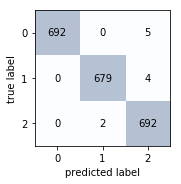

In [462]:
plot_confusion_matrix(mat)

In [463]:
cohen_kappa_score(rtesty, pred)

0.99204403782342676

In [60]:
pprint(classification_report(testY, pred))

('             precision    recall  f1-score   support\n'
 '\n'
 '          0       1.00      1.00      1.00       134\n'
 '          1       1.00      1.00      1.00       241\n'
 '          2       1.00      0.99      1.00       125\n'
 '\n'
 'avg / total       1.00      1.00      1.00       500\n')


In [464]:
sklearn.metrics.recall_score(rtesty, pred, average='weighted')

0.99469623915139826

In [465]:
sklearn.metrics.f1_score(rtesty, pred, average='weighted')

0.99468939225686048

In [466]:
mean_absolute_error(rtesty, pred)

0.0077145612343297977

In [467]:
np.sqrt(sklearn.metrics.mean_squared_error(rtesty, pred))

0.11196500348674099

In [65]:
sklearn.metrics.r2_score(testY, pred)

0.99613657963668389

In [468]:
sklearn.metrics.precision_score(rtesty, pred, average='weighted')

0.99470945425545931

In [67]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(testY, pred, pos_label=1)
print("DecisionTree AUC: {}".format(sklearn.metrics.auc(fpr, tpr)))

DecisionTree AUC: 0.5193050193050194


In [68]:
sklearn.tree.export_graphviz(dt, out_file='tree.dot')

# GradientBoosting

In [120]:
gb = GradientBoostingClassifier(verbose=1)

In [121]:
gb.fit(train_features, klabels)

      Iter       Train Loss   Remaining Time 
         1        4540.3302            3.28s
         2        4529.7387            3.02s
         3        4520.4157            2.94s
         4        4512.3542            2.91s
         5        4503.8553            2.88s
         6        4496.8919            2.83s
         7        4490.0376            2.80s
         8        4481.8719            2.85s
         9        4474.8695            2.92s
        10        4468.5091            2.98s
        20        4409.3087            3.02s
        30        4354.9933            2.45s
        40        4309.8431            2.02s
        50        4266.4394            1.66s
        60        4225.9586            1.30s
        70        4181.0700            0.96s
        80        4145.7410            0.64s
        90        4105.8343            0.32s
       100        4073.1583            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=1, warm_start=False)

In [123]:
gb.score(test_features.toarray(), xlabels)

0.32086109687339825

In [124]:
from sklearn.externals import joblib
import pickle
with open('gradientboost.pkl', 'wb') as f:
    pickle.dump(gb, f)

In [347]:
scores = cross_val_score(gb, reviews, klabels, cv=5)

      Iter       Train Loss   Remaining Time 
         1        4404.2769            4.50s
         2        4374.5150            4.45s
         3        4347.6583            4.42s
         4        4324.0482            4.39s
         5        4303.1291            4.81s
         6        4284.2794            5.09s
         7        4267.5294            5.22s
         8        4252.6551            5.13s
         9        4237.5802            5.00s
        10        4218.7461            4.86s
        20        4087.3293            3.87s
        30        4005.0404            3.16s
        40        3931.8166            2.80s
        50        3860.8624            2.32s
        60        3798.4254            1.89s
        70        3732.3878            1.43s
        80        3679.6296            0.98s
        90        3626.2559            0.49s
       100        3580.7405            0.00s
      Iter       Train Loss   Remaining Time 
         1        4404.2296            5.49s
        

In [348]:
scores

array([ 0.49418605,  0.48787585,  0.51747573,  0.49076774,  0.50923226])

In [472]:
pred = gb.predict(test_features.toarray())

In [473]:
mat = confusion_matrix(pred, rtesty)

(<matplotlib.figure.Figure at 0x124835a58>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1248343c8>)

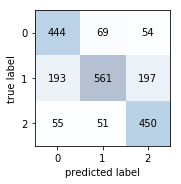

In [474]:
plot_confusion_matrix(mat)

In [475]:
cohen_kappa_score(rtesty, pred)

0.55294953381678247

In [114]:
pprint(classification_report(testY, pred))

('             precision    recall  f1-score   support\n'
 '\n'
 '          0       0.83      0.52      0.64       133\n'
 '          1       0.56      0.94      0.70       224\n'
 '          2       0.83      0.24      0.38       143\n'
 '\n'
 'avg / total       0.71      0.63      0.59       500\n')


In [476]:
sklearn.metrics.recall_score(rtesty, pred, average='weighted')

0.70154291224686594

In [477]:
sklearn.metrics.f1_score(rtesty, pred, average='weighted')

0.70307589832119122

In [478]:
mean_absolute_error(rtesty, pred)

0.35101253616200578

In [479]:
np.sqrt(sklearn.metrics.mean_squared_error(rtesty, pred))

0.67536910869520028

In [119]:
sklearn.metrics.r2_score(testY, pred)

0.24220449601160243

In [480]:
sklearn.metrics.precision_score(rtesty, pred, average='weighted')

0.728527128756984

In [121]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(testY, pred, pos_label=1)
print("DecisionTree AUC: {}".format(sklearn.metrics.auc(fpr, tpr)))

DecisionTree AUC: 0.5615052406832298


# BernoulliNB

In [125]:
bnb = BernoulliNB()

In [126]:
bnb.fit(train_features, klabels)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [127]:
bnb.score(test_features, xlabels)

0.33059969246540238

In [128]:
from sklearn.externals import joblib
with open('bernoullinb.pkl', 'wb') as f:
    pickle.dump(bnb, f)

In [239]:
scores = cross_val_score(bnb, reviews, klabels, cv=5)

In [240]:
scores

array([ 0.32073643,  0.30455868,  0.40679612,  0.35860058,  0.30126336])

In [484]:
pr = bnb.predict(test_features)

In [485]:
mat =  confusion_matrix(pr, rtesty)

(<matplotlib.figure.Figure at 0x124862358>,
 <matplotlib.axes._subplots.AxesSubplot at 0x124856908>)

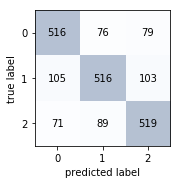

In [486]:
plot_confusion_matrix(mat)

In [487]:
cohen_kappa_score(rtesty, pr)

0.62180744815159472

In [488]:
sklearn.metrics.recall_score(rtesty, pr, average='weighted')

0.74783027965284476

In [489]:
sklearn.metrics.f1_score(rtesty, pr, average='weighted')

0.74803850157971563

In [490]:
mean_absolute_error(rtesty, pr)

0.32449373191899711

In [491]:
np.sqrt(sklearn.metrics.mean_squared_error(rtesty, pr))

0.68493923457682049

In [251]:
sklearn.metrics.r2_score(testY, pr)

-1.1901476595336051

In [492]:
sklearn.metrics.precision_score(rtesty, pr, average='weighted')

0.74894818138887853

In [254]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(testY, pr, pos_label=1)
print("BernoulliNB AUC: {}".format(sklearn.metrics.auc(fpr, tpr)))

BernoulliNB AUC: 0.47993844567266636


# MaxEnt classifier

In [56]:
maxent = nltk.MaxentClassifier.train(trainx, algorithm='gis')

ValueError: too many values to unpack (expected 2)

In [54]:
print( 'accuracy:', nltk.classify.util.accuracy(maxent, testx))

accuracy: 0.8350217076700435


In [55]:
with open('maxent.pkl', 'wb') as f:
    pickle.dump(maxent, f, protocol=2)

In [495]:
predicts = []
for i in testx:
    if maxent.classify(i[0]) == 'pos':
        predicts.append(2)
    if maxent.classify(i[0]) == 'neg':
        predicts.append(0)
    if maxent.classify(i[0]) == 'neu':
        predicts.append(1)

In [496]:
matrix = confusion_matrix(predicts, testy)

(<matplotlib.figure.Figure at 0x1249045c0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1248b4400>)

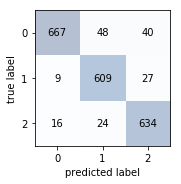

In [497]:
plot_confusion_matrix(matrix)

In [498]:
cohen_kappa_score(testy, predicts)

0.88137399090502311

In [499]:
sklearn.metrics.recall_score(testy, predicts, average='weighted')

0.92092574734811961

In [500]:
sklearn.metrics.f1_score(testy, predicts, average='weighted')

0.92089841285768459

In [501]:
mean_absolute_error(testy, predicts)

0.10607521697203472

In [502]:
np.sqrt(sklearn.metrics.mean_squared_error(testy, predicts))

0.40009642039431359

In [155]:
sklearn.metrics.r2_score(testy, predicts)

0.99463731886688722

In [503]:
sklearn.metrics.precision_score(testy, predicts, average='weighted')

0.92272486506499229

In [157]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(testy, predicts, pos_label=1)
print("MaxENT AUC: {}".format(sklearn.metrics.auc(fpr, tpr)))

MaxENT AUC: 0.48794589821435885
